<a href="https://colab.research.google.com/github/cplAloysius/FYP-Gesture-Controlled-Robotic-Arm/blob/main/Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install requirements

In [ ]:
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow

## Import libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter

## Data Analysis

Performing data analysis on first and last fist gesture record

In [ ]:
fist = pd.read_csv("/content/fist.csv")
random = pd.read_csv("/content/random.csv")
SAMPLES_PER_GESTURE = 104

In [ ]:
def get_nth_record(df, record_index, record_length):
  record_index = record_index - 1
  start_idx = record_index * record_length
  end_idx = start_idx + record_length
  record = df.iloc[start_idx:end_idx]
  return record

def get_num_records(df):
  return len(df) // SAMPLES_PER_GESTURE

In [ ]:
print("No. of fist records:", get_num_records(fist))
print("No. of random records:", get_num_records(random))

No. of fist records: 200
No. of random records: 200


In [ ]:
first_fist = get_nth_record(fist, 1, SAMPLES_PER_GESTURE)
last_fist = fist.tail(SAMPLES_PER_GESTURE)

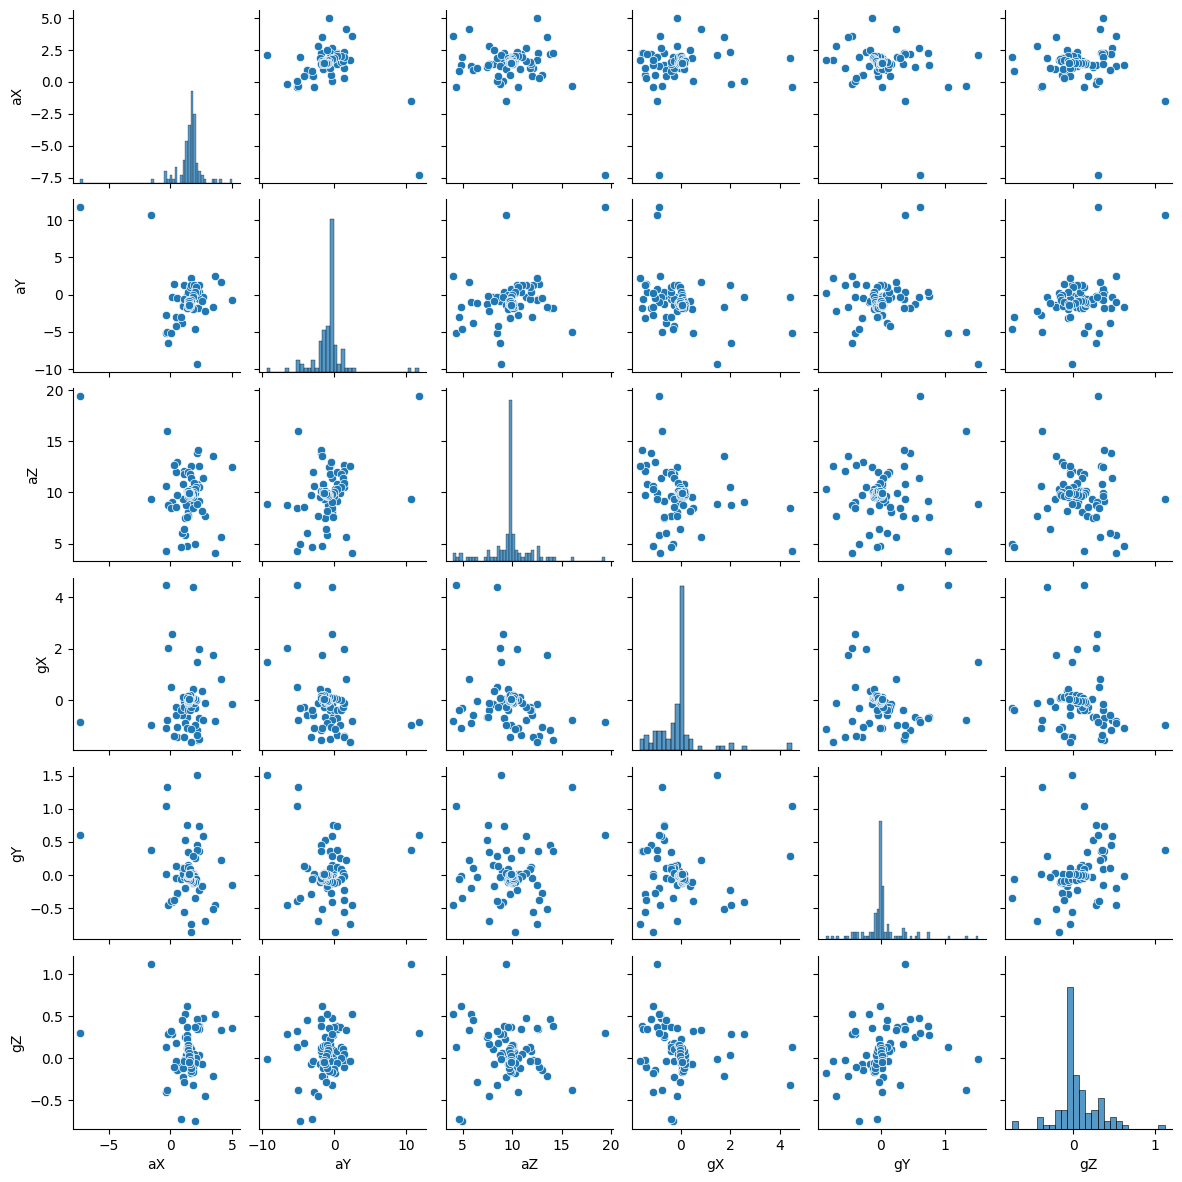

In [ ]:
sns.pairplot(first_fist, height=2)

### Accelerometer and gyroscope time series graph for first fist gesture record

<Figure size 800x600 with 0 Axes>

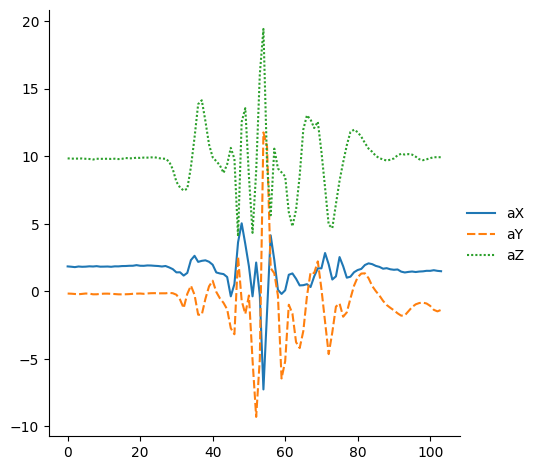

<Figure size 800x600 with 0 Axes>

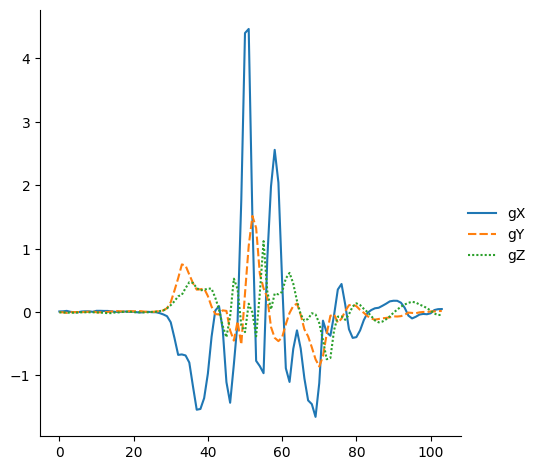

In [ ]:
accel_fist = first_fist[['aX', 'aY', 'aZ']]
gyro_fist = first_fist[['gX', 'gY', 'gZ']]

plt.figure(figsize=(8,6))
sns.relplot(data=accel_fist, kind='line')

plt.figure(figsize=(8,6))
sns.relplot(data=gyro_fist, kind='line')

### Accelerometer and gyroscope time series graph for last fist gesture record

<Figure size 800x600 with 0 Axes>

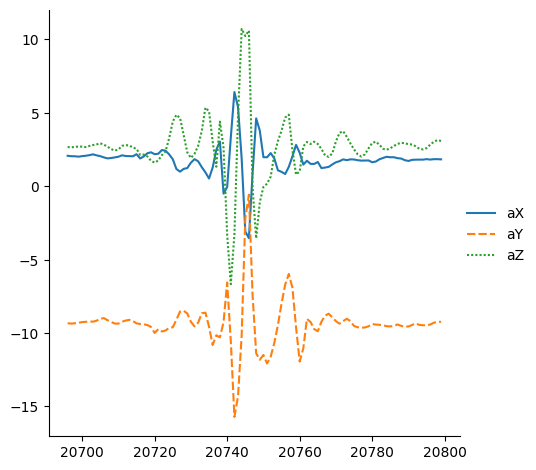

<Figure size 800x600 with 0 Axes>

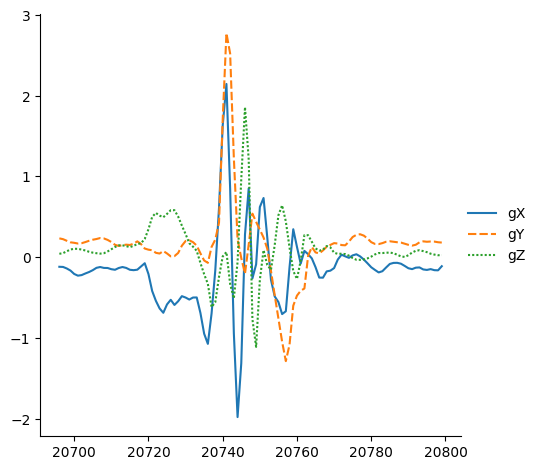

In [ ]:
accel_fist_last = last_fist[['aX', 'aY', 'aZ']]
gyro_fist_last = last_fist[['gX', 'gY', 'gZ']]

plt.figure(figsize=(8,6))
sns.relplot(data=accel_fist_last, kind='line')

plt.figure(figsize=(8,6))
sns.relplot(data=gyro_fist_last, kind='line')

### Heatmap for raw data

In [ ]:
pca_fist = decomposition.PCA()
fist_pca = pca_fist.fit_transform(first_fist[['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ']])
print(pca_fist.explained_variance_ratio_)
fist_comps = pd.DataFrame(pca_fist.components_, columns=['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ'])

[0.56537671 0.26740126 0.09771866 0.05725755 0.00899567 0.00325016]


<Axes: >

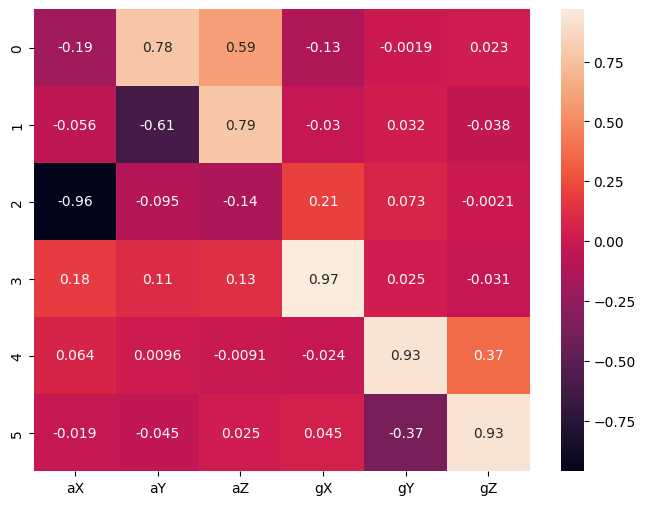

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(fist_comps, annot=True)

### Heatmap for normalised data

might want to normalise due to the difference in range and units between accel and gyro data

In [ ]:
pre_norm_fist = first_fist[['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ']].values
min_max_scaler = preprocessing.MinMaxScaler()
fist_scaler = min_max_scaler.fit_transform(pre_norm_fist)
fist_scaled = pd.DataFrame(fist_scaler, columns=['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ'])

pca_fist = decomposition.PCA()
fist_pump_pca = pca_fist.fit_transform(fist_scaled[['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ']])
print(pca_fist.explained_variance_ratio_)
fist_comps = pd.DataFrame(pca_fist.components_, columns=['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ'])

[0.31627311 0.23401789 0.17940824 0.1371888  0.07809332 0.05501864]


<Axes: >

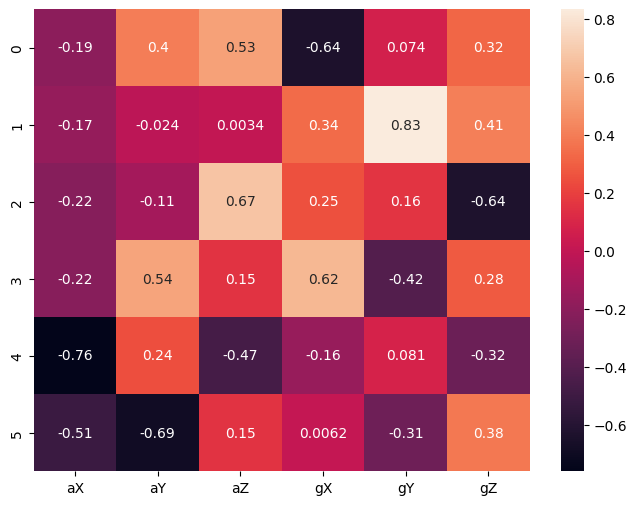

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(fist_comps, annot=True)

## Data Augmentation

Augmenting data by:

1. Sliding the time series data forward and backwards

In [ ]:
def slide(df, record_length, max_shift, step):
  augmented_records = []

  # Iterate through each record in the DataFrame
  num_records = len(df) // record_length
  for record_index in range(num_records):
    start_idx = record_index * record_length
    end_idx = start_idx + record_length
    record = df.iloc[start_idx:end_idx].values

    # Shift forward
    for shift in range(step, max_shift + 1, step):  # Forward shifts from 1 to 10
      shifted_record = record[shift:]  # Remove leading samples
      padded_record = np.pad(shifted_record, ((0, shift), (0, 0)), mode='edge')  # Pad the end
      augmented_records.append(padded_record)

    # Shift backward
    for shift in range(step, max_shift + 1, step):  # Backward shifts from 1 to 10
      shifted_record = record[:-shift]  # Remove trailing samples
      padded_record = np.pad(shifted_record, ((shift, 0), (0, 0)), mode='edge')  # Pad the start
      augmented_records.append(padded_record)

  augmented_df = pd.DataFrame(np.vstack(augmented_records), columns=['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ'])

  return augmented_df

In [ ]:
shift = 20
step = 5

augmented_fist = slide(fist, SAMPLES_PER_GESTURE, shift, step)
total_fist = pd.concat([fist, augmented_fist], ignore_index=True)

augmented_random = slide(random, SAMPLES_PER_GESTURE, shift, step)
total_random = pd.concat([random, augmented_random], ignore_index=True)

print("No. of original fist records:", get_num_records(fist))
print("Total no. of fist records after augmentation:", get_num_records(total_fist))
print()
print("No. of original random records:", get_num_records(random))
print("Total no. of random records after augmentation:", get_num_records(total_random))

No. of original fist records: 200
Total no. of fist records after augmentation: 1800

No. of original random records: 200
Total no. of random records after augmentation: 1800


##RESHAPING

In [ ]:
def reshape_data(df, gesture_label):
    # Calculate the number of gestures
    num_gestures = len(df) // SAMPLES_PER_GESTURE

    # Create a list to store the reshaped data
    reshaped_data = []

    for i in range(num_gestures):
        start_idx = i * SAMPLES_PER_GESTURE
        end_idx = start_idx + SAMPLES_PER_GESTURE
        gesture_data = df.iloc[start_idx:end_idx].values.tolist()
        reshaped_data.append([gesture_label, gesture_data])

    return reshaped_data

In [ ]:
fist_reshaped = reshape_data(total_fist, 0)
random_reshaped = reshape_data(total_random, 1)

# Combine the reshaped data into a single DataFrame
combined_data = fist_reshaped + random_reshaped
result_df = pd.DataFrame(combined_data, columns=['gesture', 'data'])

In [ ]:
# Initialize min and max dictionaries
min_values = {'ax': float('inf'), 'ay': float('inf'), 'az': float('inf'),
              'gx': float('inf'), 'gy': float('inf'), 'gz': float('inf')}
max_values = {'ax': float('-inf'), 'ay': float('-inf'), 'az': float('-inf'),
              'gx': float('-inf'), 'gy': float('-inf'), 'gz': float('-inf')}

# Iterate through each record and update min and max values
for index, row in result_df.iterrows():
    data = np.array(row['data'])

    ax = data[:, 0]
    ay = data[:, 1]
    az = data[:, 2]
    gx = data[:, 3]
    gy = data[:, 4]
    gz = data[:, 5]

    min_values['ax'] = min(min_values['ax'], np.min(ax))
    min_values['ay'] = min(min_values['ay'], np.min(ay))
    min_values['az'] = min(min_values['az'], np.min(az))
    min_values['gx'] = min(min_values['gx'], np.min(gx))
    min_values['gy'] = min(min_values['gy'], np.min(gy))
    min_values['gz'] = min(min_values['gz'], np.min(gz))

    max_values['ax'] = max(max_values['ax'], np.max(ax))
    max_values['ay'] = max(max_values['ay'], np.max(ay))
    max_values['az'] = max(max_values['az'], np.max(az))
    max_values['gx'] = max(max_values['gx'], np.max(gx))
    max_values['gy'] = max(max_values['gy'], np.max(gy))
    max_values['gz'] = max(max_values['gz'], np.max(gz))

print("Minimum values:")
print(min_values)

print("\nMaximum values:")
print(max_values)

Minimum values:
{'ax': -12.821, 'ay': -19.334, 'az': -11.208, 'gx': -5.101, 'gy': -3.888, 'gz': -2.733}

Maximum values:
{'ax': 15.634, 'ay': 20.08, 'az': 19.46, 'gx': 4.913, 'gy': 3.583, 'gz': 3.793}


In [ ]:
def normalize_data(data_entry):
    # Convert to a numpy array
    data_array = np.array(data_entry)

    # Normalize each feature
    normalized_data = []
    for i, feature in enumerate(['ax', 'ay', 'az', 'gx', 'gy', 'gz']):
        min_val = min_values[feature]
        max_val = max_values[feature]
        feature_data = data_array[:, i]
        normalized_feature = (feature_data - min_val) / (max_val - min_val)
        normalized_data.append(normalized_feature)

    # Combine normalized features into a single array
    return np.column_stack(normalized_data)

# Apply normalization to each record in the DataFrame
result_df['norm_data'] = result_df['data'].apply(normalize_data)

In [ ]:
# Initialize min and max dictionaries for normalized data
norm_min_values = {'ax': float('inf'), 'ay': float('inf'), 'az': float('inf'),
                   'gx': float('inf'), 'gy': float('inf'), 'gz': float('inf')}
norm_max_values = {'ax': float('-inf'), 'ay': float('-inf'), 'az': float('-inf'),
                   'gx': float('-inf'), 'gy': float('-inf'), 'gz': float('-inf')}

# Iterate through each record and update min and max values for normalized data
for index, row in result_df.iterrows():
    norm_data = np.array(row['norm_data'])

    ax = norm_data[:, 0]
    ay = norm_data[:, 1]
    az = norm_data[:, 2]
    gx = norm_data[:, 3]
    gy = norm_data[:, 4]
    gz = norm_data[:, 5]

    norm_min_values['ax'] = min(norm_min_values['ax'], np.min(ax))
    norm_min_values['ay'] = min(norm_min_values['ay'], np.min(ay))
    norm_min_values['az'] = min(norm_min_values['az'], np.min(az))
    norm_min_values['gx'] = min(norm_min_values['gx'], np.min(gx))
    norm_min_values['gy'] = min(norm_min_values['gy'], np.min(gy))
    norm_min_values['gz'] = min(norm_min_values['gz'], np.min(gz))

    norm_max_values['ax'] = max(norm_max_values['ax'], np.max(ax))
    norm_max_values['ay'] = max(norm_max_values['ay'], np.max(ay))
    norm_max_values['az'] = max(norm_max_values['az'], np.max(az))
    norm_max_values['gx'] = max(norm_max_values['gx'], np.max(gx))
    norm_max_values['gy'] = max(norm_max_values['gy'], np.max(gy))
    norm_max_values['gz'] = max(norm_max_values['gz'], np.max(gz))

print("Normalized minimum values:")
print(norm_min_values)

print("\nNormalized maximum values:")
print(norm_max_values)

Normalized minimum values:
{'ax': 0.0, 'ay': 0.0, 'az': 0.0, 'gx': 0.0, 'gy': 0.0, 'gz': 0.0}

Normalized maximum values:
{'ax': 1.0, 'ay': 1.0, 'az': 1.0, 'gx': 1.0, 'gy': 1.0, 'gz': 1.0}


## Data preparation

Generating inputs (noramlised data) and outputs (one hot encoded label for respective input) array used for training the model.

Also calculating and displaying the constants used for normalisation, needed for deploying the model.

In [ ]:
print(f"TensorFlow version = {tf.__version__}\n")

# fixed seed value
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

GESTURES = [
    "fist",
    "random",
]

NUM_GESTURES = len(GESTURES)

num_fist_records = 0
num_rand_records = 0

# (1,0): fist
# (0,1): random
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  #df = pd.read_csv("/content/" + gesture + ".csv")
  if (gesture == "fist"):
    df = total_fist
    #df = fist
  else:
    df = total_random
    #df = random

  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

  if (gesture == 'fist'):
    num_fist_records = num_recordings
  else:
    num_rand_records = num_recordings

  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalise the input data between 0 to 1:
      tensor += [
          df['aX'][index],
          df['aY'][index],
          df['aZ'][index],
          df['gX'][index],
          df['gY'][index],
          df['gZ'][index]
      ]

    inputs.append(tensor)
    outputs.append(output)

inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.\n")

print("Min value in inputs:", np.min(inputs))
print("Max value in inputs:", np.max(inputs), "\n")

TensorFlow version = 2.17.0

Processing index 0 for gesture 'fist'.
	There are 1800 recordings of the fist gesture.
Processing index 1 for gesture 'random'.
	There are 1800 recordings of the random gesture.
Data set parsing and preparation complete.

Min value in inputs: -19.334
Max value in inputs: 20.08 



Fist closure gestures are recorded in different orientations. Each orientation has 40 records.

Various random gestures, that should not be recognised as a fist closure, are captured. Each random gesture has 20 records.

The aim is to create labels for each "type" of records and the labels to split the records evenly among train, test and validation sets

In [ ]:
labels = []

fist_rec_per_group = 40
rand_rec_per_group = 20
aug_fist_rec_per_group = fist_rec_per_group * ((shift//step)*2)
aug_rand_rec_per_group = rand_rec_per_group * ((shift//step)*2)

for i in range(5):
  label = f"fist_{i}"
  labels.extend([label] * fist_rec_per_group)

for i in range(5):
  label = f"fist_{i+5}"
  labels.extend([label] * aug_fist_rec_per_group)

for i in range(10):
  label = f"random_{i}"
  labels.extend([label] * rand_rec_per_group)

for i in range(10):
  label = f"random_{i+10}"
  labels.extend([label] * aug_rand_rec_per_group)

print("Labels array generation complete.")
print(f"Label distribution: {Counter(labels)}")

Labels array generation complete.
Label distribution: Counter({'fist_5': 320, 'fist_6': 320, 'fist_7': 320, 'fist_8': 320, 'fist_9': 320, 'random_10': 160, 'random_11': 160, 'random_12': 160, 'random_13': 160, 'random_14': 160, 'random_15': 160, 'random_16': 160, 'random_17': 160, 'random_18': 160, 'random_19': 160, 'fist_0': 40, 'fist_1': 40, 'fist_2': 40, 'fist_3': 40, 'fist_4': 40, 'random_0': 20, 'random_1': 20, 'random_2': 20, 'random_3': 20, 'random_4': 20, 'random_5': 20, 'random_6': 20, 'random_7': 20, 'random_8': 20, 'random_9': 20})


## test

In [ ]:
result_df['label'] = labels

In [ ]:
result_df.drop(columns=['data'], inplace=True)

In [ ]:
gesture_0_df = result_df[result_df['gesture'] == 0]
gesture_1_df = result_df[result_df['gesture'] == 1]

In [ ]:
SEED = 1337

gesture_0_train, gesture_0_test = train_test_split(gesture_0_df, test_size=0.2, random_state=SEED, stratify=gesture_0_df['label'])
gesture_0_train, gesture_0_validate = train_test_split(gesture_0_train, test_size=0.25, random_state=SEED, stratify=gesture_0_train['label'])

gesture_1_train, gesture_1_test = train_test_split(gesture_1_df, test_size=0.2, random_state=SEED, stratify=gesture_1_df['label'])
gesture_1_train, gesture_1_validate = train_test_split(gesture_1_train, test_size=0.25, random_state=SEED, stratify=gesture_1_train['label'])

In [ ]:
train_df = pd.concat([gesture_0_train, gesture_1_train])
validate_df = pd.concat([gesture_0_validate, gesture_1_validate])
test_df = pd.concat([gesture_0_test, gesture_1_test])

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
validate_df = validate_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
train_df.drop(columns=['label'], inplace=True)
validate_df.drop(columns=['label'], inplace=True)
test_df.drop(columns=['label'], inplace=True)

In [ ]:
tensor_train_set = tf.data.Dataset.from_tensor_slices(
    (np.array(train_df['norm_data'].tolist(),dtype=np.float64),
     train_df['gesture'].tolist()))

tensor_test_set = tf.data.Dataset.from_tensor_slices(
    (np.array(test_df['norm_data'].tolist(),dtype=np.float64),
     test_df['gesture'].tolist()))

tensor_val_set = tf.data.Dataset.from_tensor_slices(
    (np.array(validate_df['norm_data'].tolist(),dtype=np.float64),
     validate_df['gesture'].tolist()))

In [ ]:
def reshape_function(data, label):
    reshaped_data = tf.reshape(data, [-1, 6, 1])
    return reshaped_data, label

In [ ]:
tensor_train_set_cnn = tensor_train_set.map(reshape_function)
tensor_test_set_cnn = tensor_test_set.map(reshape_function)
tensor_val_set_cnn = tensor_val_set.map(reshape_function)

In [ ]:
batch_size = 64

tensor_train_set_cnn = tensor_train_set_cnn.batch(batch_size).repeat()
tensor_test_set_cnn = tensor_test_set_cnn.batch(batch_size)
tensor_val_set_cnn = tensor_val_set_cnn.batch(batch_size)

##OLD

In [ ]:
labels = np.array(labels)

inputs_train, inputs_test, outputs_train, outputs_test, labels_train, labels_test = train_test_split(
    inputs, outputs, labels, test_size=0.2, random_state=SEED, stratify=labels)

inputs_train, inputs_validate, outputs_train, outputs_validate = train_test_split(
    inputs_train, outputs_train, test_size=0.25, random_state=SEED, stratify=labels_train)

print("Data randomization and splitting complete.")

print("Min value in training inputs:", inputs_train.min())
print("Max value in training inputs:", inputs_train.max(), "\n")

print("Min value in test inputs:", inputs_test.min())
print("Max value in test inputs:", inputs_test.max(), "\n")

print("Min value in validation inputs:", inputs_validate.min())
print("Max value in validation inputs:", inputs_validate.max())

Data randomization and splitting complete.
Min value in training inputs: -19.334
Max value in training inputs: 20.08 

Min value in test inputs: -19.334
Max value in test inputs: 20.08 

Min value in validation inputs: -19.334
Max value in validation inputs: 20.08


In [ ]:
ax_list = []
ay_list = []
az_list = []
gx_list = []
gy_list = []
gz_list = []

for i in range (len(inputs_train)):
  for j in range (0, len(inputs_train[0]), 6):
    ax_list.append(inputs_train[i][j])
  for j in range(1, len(inputs_train[0]), 6):
    ay_list.append(inputs_train[i][j])
  for j in range(2, len(inputs_train[0]), 6):
    az_list.append(inputs_train[i][j])
  for j in range(3, len(inputs_train[0]), 6):
    gx_list.append(inputs_train[i][j])
  for j in range(4, len(inputs_train[0]), 6):
    gy_list.append(inputs_train[i][j])
  for j in range(5, len(inputs_train[0]), 6):
    gz_list.append(inputs_train[i][j])

ax_min = min(ax_list)
ay_min = min(ay_list)
az_min = min(az_list)
gx_min = min(gx_list)
gy_min = min(gy_list)
gz_min = min(gz_list)

ax_max = max(ax_list)
ay_max = max(ay_list)
az_max = max(az_list)
gx_max = max(gx_list)
gy_max = max(gy_list)
gz_max = max(gz_list)

print("ax_min=",ax_min, ", ay_min=", ay_min, ", az_min=", az_min, ", gx_min=", gx_min, ", gy_min=", gy_min, ", gz_min=", gz_min)
print("ax_max=",ax_max, ", ay_max=", ay_max, ", az_max=", az_max, ", gx_max=", gx_max, ", gy_max=", gy_max, ", gz_max=", gz_max)

ax_min= -12.821 , ay_min= -19.334 , az_min= -11.208 , gx_min= -5.101 , gy_min= -3.888 , gz_min= -2.733
ax_max= 15.634 , ay_max= 20.08 , az_max= 19.46 , gx_max= 4.913 , gy_max= 3.583 , gz_max= 3.793


In [ ]:
#inputs_train
inputs_train_reshaped = inputs_train.reshape(-1, SAMPLES_PER_GESTURE, 6)

min_values = np.array([ax_min, ay_min, az_min, gx_min, gy_min, gz_min])
max_values = np.array([ax_max, ay_max, az_max, gx_max, gy_max, gz_max])

for i in range(6):
    feature_min = min_values[i]
    feature_max = max_values[i]
    inputs_train_reshaped[:, :, i] = (inputs_train_reshaped[:, :, i] - feature_min) / (feature_max - feature_min)

inputs_train = inputs_train_reshaped.flatten().reshape(inputs_train.shape)

#inputs_test
inputs_test_reshaped = inputs_test.reshape(-1, SAMPLES_PER_GESTURE, 6)

for i in range(6):
    feature_min = min_values[i]
    feature_max = max_values[i]
    inputs_test_reshaped[:, :, i] = (inputs_test_reshaped[:, :, i] - feature_min) / (feature_max - feature_min)

inputs_test = inputs_test_reshaped.flatten().reshape(inputs_test.shape)

#inputs_validate
inputs_validate_reshaped = inputs_validate.reshape(-1, SAMPLES_PER_GESTURE, 6)

for i in range(6):
    feature_min = min_values[i]
    feature_max = max_values[i]
    inputs_validate_reshaped[:, :, i] = (inputs_validate_reshaped[:, :, i] - feature_min) / (feature_max - feature_min)

inputs_validate = inputs_validate_reshaped.flatten().reshape(inputs_validate.shape)



print("Min value in normalized inputs_train:", inputs_train.min())
print("Max value in normalized inputs_train:", inputs_train.max(), "\n")
print("Min value in normalized inputs_test:", inputs_test.min())
print("Max value in normalized inputs_test:", inputs_test.max(), "\n")
print("Min value in normalized inputs_validate:", inputs_validate.min())
print("Max value in normalized inputs_validate:", inputs_validate.max(), "\n")

Min value in normalized inputs_train: 0.0
Max value in normalized inputs_train: 1.0 

Min value in normalized inputs_test: 0.0
Max value in normalized inputs_test: 1.0 

Min value in normalized inputs_validate: 0.0
Max value in normalized inputs_validate: 1.0 



In [ ]:
inputs_train = inputs_train.reshape(-1, SAMPLES_PER_GESTURE, 6, 1)
inputs_test = inputs_test.reshape(-1, SAMPLES_PER_GESTURE, 6, 1)
inputs_validate = inputs_validate.reshape(-1, SAMPLES_PER_GESTURE, 6, 1)

## Training the model

'softmax' gives the probability of the gesture being in a specific class.

'categorical_crossentropy' is used as output labels are one hot encoded.

Learning rate reduced from default of 0.001 to 0.0005 for more consistent training

In [ ]:
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    verbose = 1,
    mode = 'min',
    restore_best_weights = True
)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (10, 3), activation='relu', padding='same', input_shape=(SAMPLES_PER_GESTURE, 6, 1)), #(batch, 104, 6, 8), (10, 6) means model looks at 10 time steps and all 6 features each time
    tf.keras.layers.MaxPooling2D((2,6)), #(batch, 52, 1, 8), (2, 6) reduces the first dim by a factor of 2 and the 2nd dim by factor of 6
    tf.keras.layers.Dropout(0.1), #(batch, 52, 1, 8)

    # tf.keras.layers.Conv2D(16, (20, 1), activation='relu', padding='same'), #(batch, 52, 1, 16)
    # tf.keras.layers.MaxPooling2D((2,1)), #(batch, 26, 1, 16)
    # tf.keras.layers.Dropout(0.1), #(batch, 26, 1, 16)

    tf.keras.layers.Flatten(), #(batch, 416)

    tf.keras.layers.Dense(8, activation='relu'), #(batch, 16)
    tf.keras.layers.Dropout(0.1), #(batch, 16)
    tf.keras.layers.Dense(NUM_GESTURES, activation='softmax') #(batch, 2)
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(inputs_train, outputs_train, epochs=30, batch_size=64, validation_data=(inputs_validate, outputs_validate))

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.4908 - loss: 0.7211 - val_accuracy: 0.7167 - val_loss: 0.6622
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6349 - loss: 0.6613 - val_accuracy: 0.7375 - val_loss: 0.6169
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7503 - loss: 0.6011 - val_accuracy: 0.8000 - val_loss: 0.5414
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8461 - loss: 0.5180 - val_accuracy: 0.9903 - val_loss: 0.4216
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9253 - loss: 0.4175 - val_accuracy: 0.9931 - val_loss: 0.3203
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9606 - loss: 0.3182 - val_accuracy: 0.9944 - val_loss: 0.2247
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9726 - loss: 0.2334 - val_accuracy: 0.9931 - val_loss: 0.1619
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9771 - loss: 0.1678 - val_accuracy: 0.9958 - v

In [ ]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Dense(50, activation='relu'))
model2.add(tf.keras.layers.Dense(15, activation='relu'))
model2.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax'))
model2.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(inputs_train, outputs_train, epochs=300, batch_size=1, validation_data=(inputs_validate, outputs_validate), callbacks=[early_stopping])

Epoch 1/300
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5944 - loss: 0.6714 - val_accuracy: 0.6583 - val_loss: 0.6060
Epoch 2/300
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7092 - loss: 0.5808 - val_accuracy: 0.7514 - val_loss: 0.5375
Epoch 3/300
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7594 - loss: 0.5123 - val_accuracy: 0.8042 - val_loss: 0.4881
Epoch 4/300
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7834 - loss: 0.4576 - val_accuracy: 0.8444 - val_loss: 0.4372
Epoch 5/300
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8155 - loss: 0.4099 - val_accuracy: 0.8792 - val_loss: 0.4068
Epoch 6/300
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8332 - loss: 0.3693 - val_accuracy: 0.8722 - val_loss: 0.3615
Epoch 7/300
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8473 - loss: 0.3331 - val_accuracy: 0.8806 - val_loss: 0.3323
Epoch 8/300
2160/2160 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8657 - loss: 0

In [ ]:
best_epoch = np.argmin(history.history['val_loss'])

best_train_loss = history.history['loss'][best_epoch]
best_train_accuracy = history.history['accuracy'][best_epoch]

best_val_loss = history.history['val_loss'][best_epoch]
best_val_accuracy = history.history['val_accuracy'][best_epoch]

print(f"Training loss at epoch {best_epoch + 1}: {best_train_loss}")
print(f"Training accuracy at epoch {best_epoch + 1}: {best_train_accuracy}\n")


print(f"Validation loss at epoch {best_epoch + 1}: {best_val_loss}")
print(f"Validation accuracy at epoch {best_epoch + 1}: {best_val_accuracy}")

Training loss at epoch 30: 0.02189483866095543
Training accuracy at epoch 30: 0.9986110925674438

Validation loss at epoch 30: 0.01263047568500042
Validation accuracy at epoch 30: 1.0


## Analysis

Training and validation loss decreases over time.

Spikes in validation loss indicates small data set size, will collect more recordings and consider data augmentation

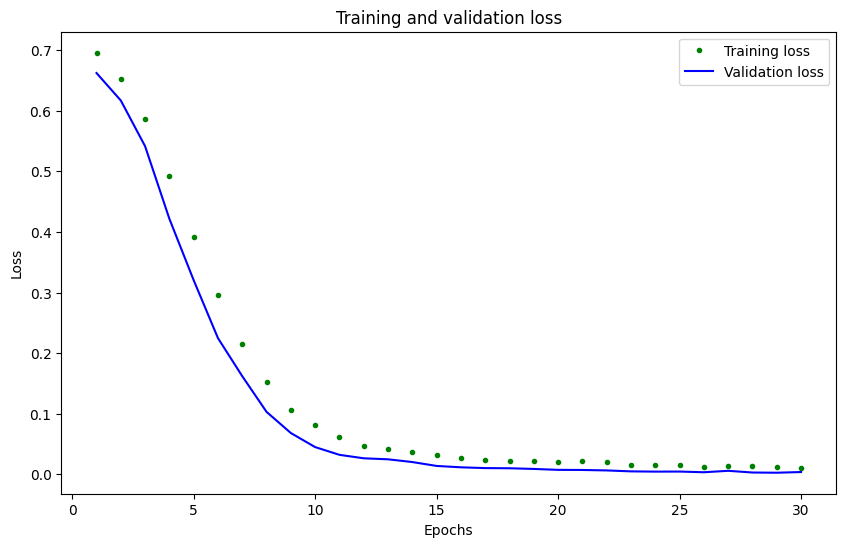

[10.0, 6.0]


In [ ]:
plt.rcParams["figure.figsize"] = (10,6)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

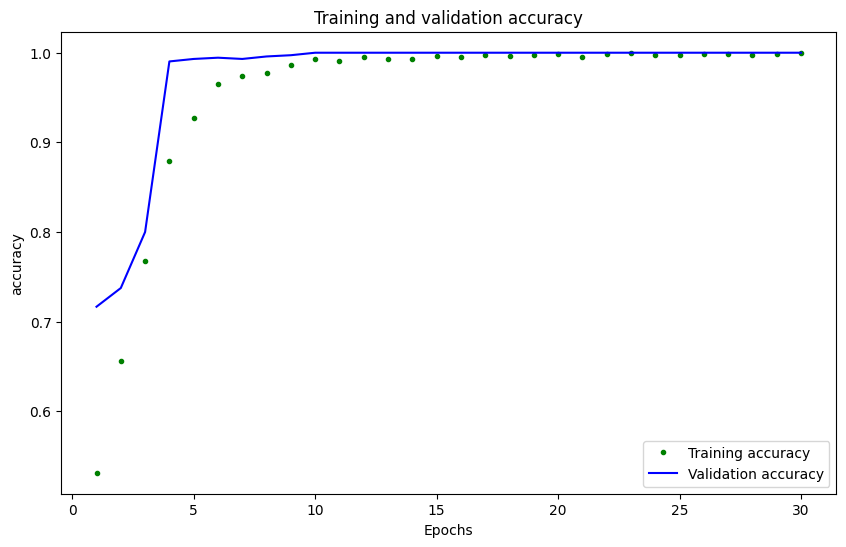

In [ ]:
SKIP = 0
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs[SKIP:], accuracy[SKIP:], 'g.', label='Training accuracy')
plt.plot(epochs[SKIP:], val_accuracy[SKIP:], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


## Testing the model

Running the model on the test data set, comparing its predictions with its output labels

In [ ]:
predictions = model.predict(inputs_test)

#print("predictions =\n", np.round(predictions, decimals=3))
#print("actual =\n", outputs_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Confusion matrix and accuracy score for the model

Confusion Matrix:
 [[360   0]
 [  0 360]]


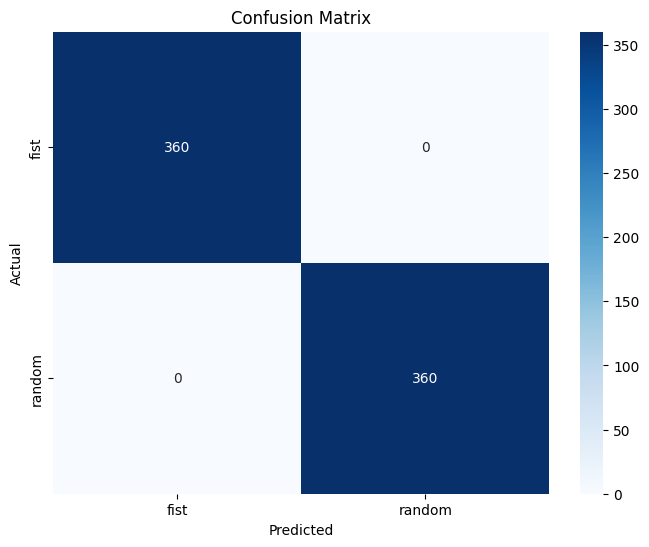

Overall Accuracy: 1.00
Class Accuracy:
 [1. 1.]


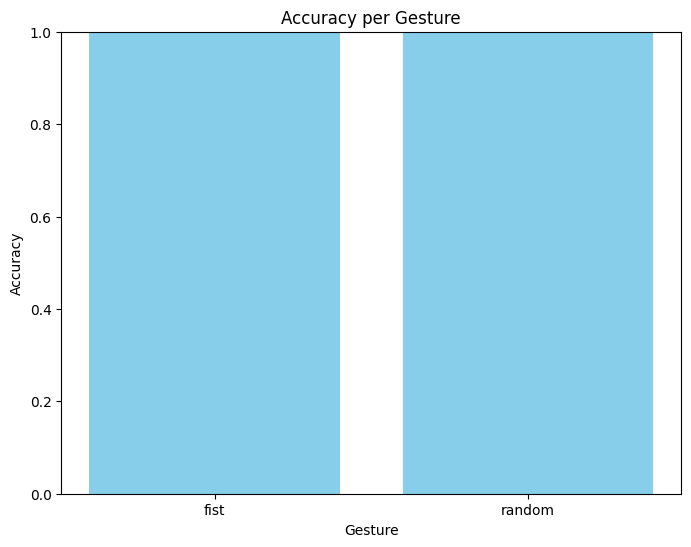

In [ ]:
# convert one-hot encoded outputs to class labels
actual_labels = np.argmax(outputs_test, axis=1)
predicted_labels = np.argmax(predictions, axis=1)

# confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=GESTURES, yticklabels=GESTURES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(actual_labels, predicted_labels)
print(f'Overall Accuracy: {accuracy:.2f}')

# accuracy for each class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("Class Accuracy:\n", class_accuracy)

plt.figure(figsize=(8, 6))
plt.bar(GESTURES, class_accuracy, color='skyblue')
plt.xlabel('Gesture')
plt.ylabel('Accuracy')
plt.title('Accuracy per Gesture')
plt.ylim([0, 1])
plt.show()

## Saving the model

Converting the model into tflite format and generating 'model.h' header file for deployment on Adafruit NRF52840 Sense on Arduino IDE

In [ ]:
model.save('gesture_model.keras')

In [ ]:
def representative_dataset():
  for i in range(100):
    yield [inputs_train[i:i+1].astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.float32  # or tf.uint8
# converter.inference_output_type = tf.float32  # or tf.uint8

converter.representative_dataset = representative_dataset

tflite_model = converter.convert()

open("gesture_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

Saved artifact at '/tmp/tmpv4vvvs71'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 104, 6, 1), dtype=tf.float32, name='keras_tensor_156')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137208009374384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137208009365936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137207906244512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137208009359424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137208009368400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137207909712816: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model is 7568 bytes


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")

Header file, model.h, is 46,704 bytes.


## Further training if required

In [ ]:
history = model.fit(inputs_train, outputs_train, epochs=100, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Epoch 1/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0673 - mae: 0.0779 - val_loss: 0.1757 - val_mae: 0.1920
Epoch 2/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0609 - mae: 0.0703 - val_loss: 0.1251 - val_mae: 0.1591
Epoch 3/100
120/120 [==============================] - 0s 3ms/step - loss: 0.0368 - mae: 0.0439 - val_loss: 0.2211 - val_mae: 0.2268
Epoch 4/100
120/120 [==============================] - 0s 3ms/step - loss: 0.0564 - mae: 0.0699 - val_loss: 0.1370 - val_mae: 0.1933
Epoch 5/100
120/120 [==============================] - 0s 3ms/step - loss: 0.0185 - mae: 0.0299 - val_loss: 0.1907 - val_mae: 0.1991
Epoch 6/100
120/120 [==============================] - 0s 3ms/step - loss: 0.0145 - mae: 0.0211 - val_loss: 0.1474 - val_mae: 0.1664
Epoch 7/100
120/120 [==============================] - 0s 4ms/step - loss: 0.0300 - mae: 0.0448 - val_loss: 0.2205 - val_mae: 0.2446
Epoch 8/100
120/120 [==============================] - 0s 3ms/step - 

## Further testing

In [ ]:
model = tf.keras.models.load_model('gesture_model.keras')

In [ ]:
test = fist

In [ ]:
test = pd.read_csv("/content/test2.csv")

In [ ]:
num = get_num_records(test)
test1 = []

for i in range(num):
  tensor = []
  for j in range(SAMPLES_PER_GESTURE):
    index = (i * SAMPLES_PER_GESTURE + j)
    tensor += [
      test['aX'][index],
      test['aY'][index],
      test['aZ'][index],
      test['gX'][index],
      test['gY'][index],
      test['gZ'][index]
    ]

  test1.append(tensor)

test1 = np.array(test1)

In [ ]:
#inputs_train
test1_reshaped = test1.reshape(-1, SAMPLES_PER_GESTURE, 6)

min_values = np.array([ax_min, ay_min, az_min, gx_min, gy_min, gz_min])
max_values = np.array([ax_max, ay_max, az_max, gx_max, gy_max, gz_max])

for i in range(6):
    feature_min = min_values[i]
    feature_max = max_values[i]
    test1_reshaped[:, :, i] = (test1_reshaped[:, :, i] - feature_min) / (feature_max - feature_min)

test1 = test1_reshaped.flatten().reshape(test1.shape)
print(np.max(test1))
print(np.min(test1))

0.9977174905438894
0.2506847528368332


In [ ]:
test1 = test1.reshape(-1, SAMPLES_PER_GESTURE, 6, 1)

In [ ]:
pred = model.predict(test1)
if (num < 10):
  print("predictions =\n", np.round(pred, decimals=3))

count1 = np.sum(pred[:, 0] > pred[:, 1])
count2 = np.sum(pred[:, 1] > pred[:, 0])

print("Number of [1, 0] predictions:", count1)
print("Number of [0, 1] predictions:", count2)

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(9, 624), dtype=float32). Expected shape (None, 104, 6, 1), but input has incompatible shape (9, 624)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(9, 624), dtype=float32)
  • training=False
  • mask=None

In [ ]:
from tflite_runtime.interpreter import Interpreter

# Load the quantized TFLite model
interpreter = Interpreter(model_path="/content/gesture_model.tflite")
interpreter.allocate_tensors()

test1 = test1.astype(np.float32)
for i in range(num):
  input_test = test1[i].reshape(1, SAMPLES_PER_GESTURE, 6, 1)
  interpreter.set_tensor(0, input_test)

  interpreter.invoke()


  output_tensor_index = output_details[0]['index']
  output_data = interpreter.get_tensor(output_tensor_index)
  print(i+1, np.round(output_data, decimals=3))

1 [[0.004 0.996]]
2 [[0.004 0.996]]
3 [[0.004 0.996]]
4 [[0.004 0.996]]
5 [[0.004 0.996]]
6 [[0.184 0.816]]
7 [[0.855 0.145]]
8 [[0.914 0.086]]
9 [[0.91 0.09]]


In [ ]:
for i in range (num):
  print(i+1, np.round(pred[i], decimals=3))

1 [1. 0.]
2 [1. 0.]
3 [1. 0.]
4 [1. 0.]
5 [1. 0.]
6 [1. 0.]
7 [1. 0.]
8 [1. 0.]
9 [1. 0.]
10 [1. 0.]
11 [1. 0.]
12 [1. 0.]
13 [1. 0.]
14 [1. 0.]
15 [1. 0.]
16 [1. 0.]
17 [1. 0.]
18 [1. 0.]
19 [1. 0.]
20 [1. 0.]
21 [1. 0.]
22 [1. 0.]
23 [1. 0.]
24 [1. 0.]
25 [1. 0.]
26 [1. 0.]
27 [1. 0.]
28 [1. 0.]
29 [1. 0.]
30 [1. 0.]
31 [1. 0.]
32 [1. 0.]
33 [1. 0.]
34 [1. 0.]
35 [1. 0.]
36 [1. 0.]
37 [1. 0.]
38 [1. 0.]
39 [1. 0.]
40 [1. 0.]
41 [1. 0.]
42 [1. 0.]
43 [1. 0.]
44 [1. 0.]
45 [1. 0.]
46 [1. 0.]
47 [1. 0.]
48 [1. 0.]
49 [1. 0.]
50 [1. 0.]
51 [1. 0.]
52 [1. 0.]
53 [1. 0.]
54 [1. 0.]
55 [1. 0.]
56 [1. 0.]
57 [1. 0.]
58 [1. 0.]
59 [1. 0.]
60 [1. 0.]
61 [1. 0.]
62 [1. 0.]
63 [1. 0.]
64 [1. 0.]
65 [1. 0.]
66 [1. 0.]
67 [1. 0.]
68 [1. 0.]
69 [1. 0.]
70 [1. 0.]
71 [1. 0.]
72 [1. 0.]
73 [1. 0.]
74 [1. 0.]
75 [1. 0.]
76 [1. 0.]
77 [1. 0.]
78 [1. 0.]
79 [1. 0.]
80 [1. 0.]
81 [1. 0.]
82 [1. 0.]
83 [1. 0.]
84 [1. 0.]
85 [1. 0.]
86 [1. 0.]
87 [1. 0.]
88 [1. 0.]
89 [1. 0.]
90 [1. 0.]
91 [1. 0.]
92 [1. 0

<ipython-input-180-071025fe4148>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,6))


<Figure size 800x600 with 0 Axes>

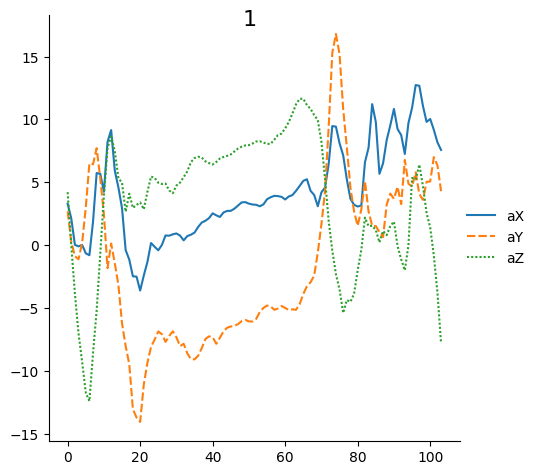

<Figure size 800x600 with 0 Axes>

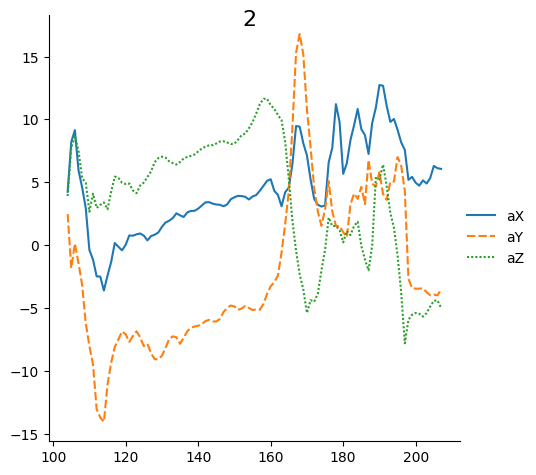

<Figure size 800x600 with 0 Axes>

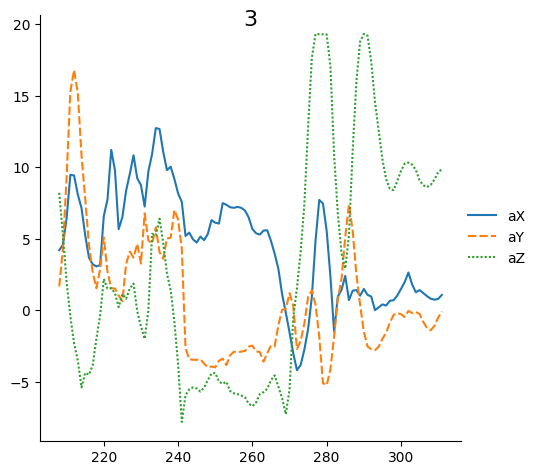

<Figure size 800x600 with 0 Axes>

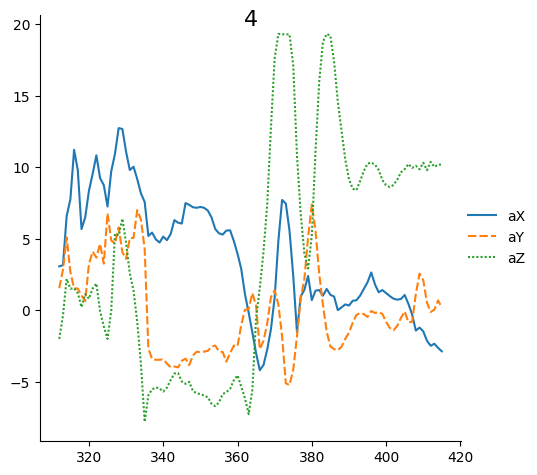

<Figure size 800x600 with 0 Axes>

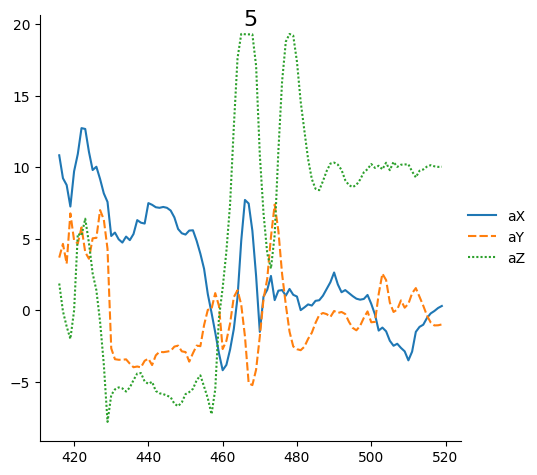

<Figure size 800x600 with 0 Axes>

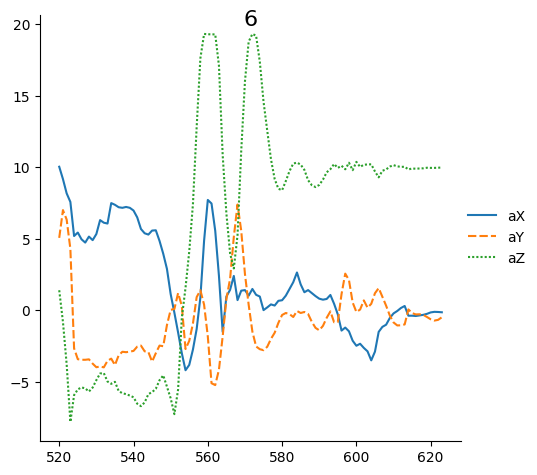

<Figure size 800x600 with 0 Axes>

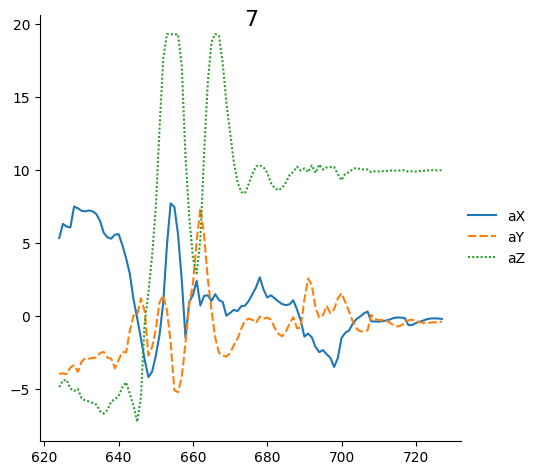

<Figure size 800x600 with 0 Axes>

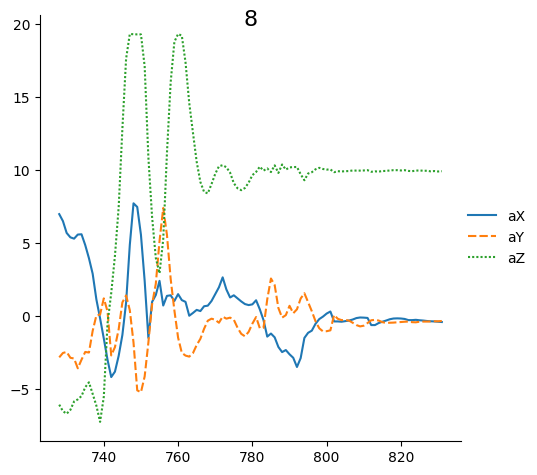

<Figure size 800x600 with 0 Axes>

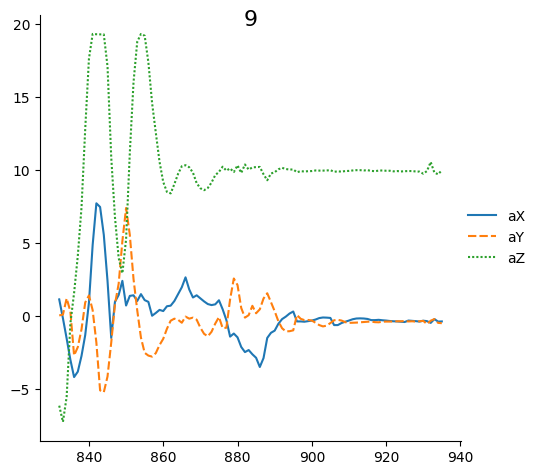

<Figure size 800x600 with 0 Axes>

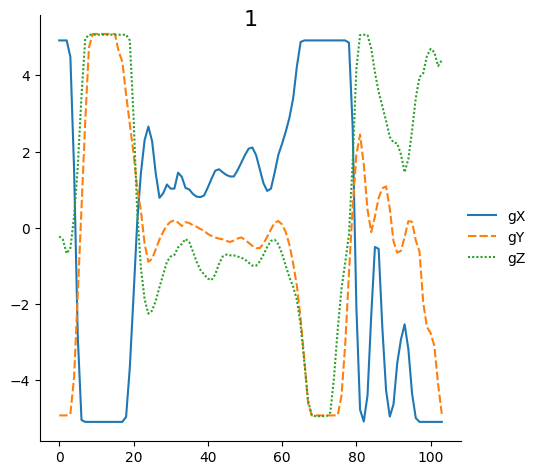

<Figure size 800x600 with 0 Axes>

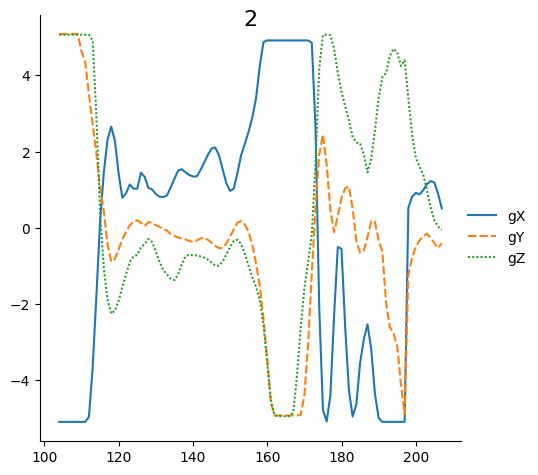

<Figure size 800x600 with 0 Axes>

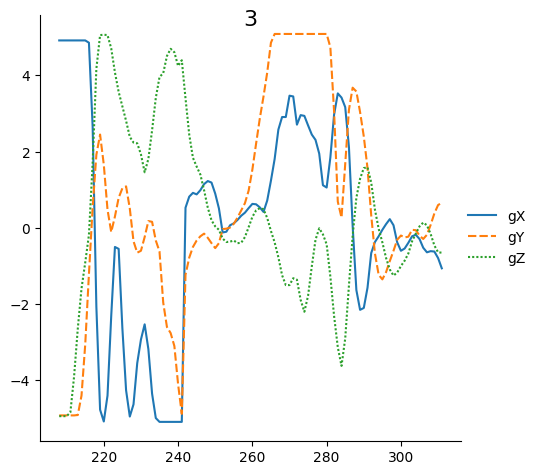

<Figure size 800x600 with 0 Axes>

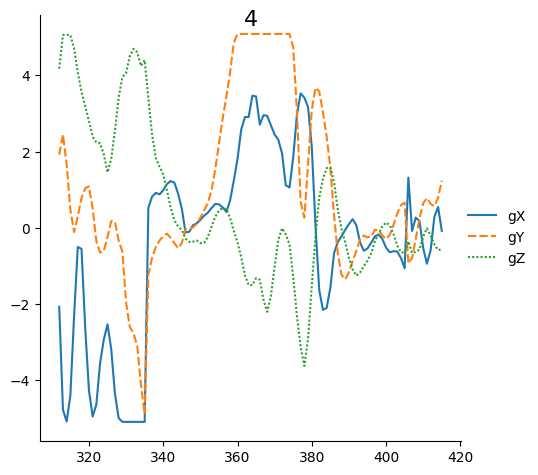

<Figure size 800x600 with 0 Axes>

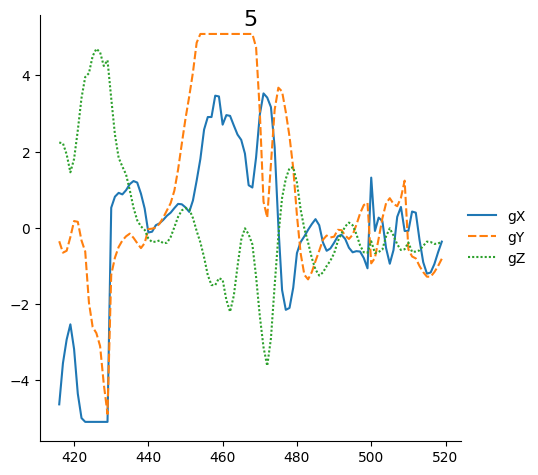

<Figure size 800x600 with 0 Axes>

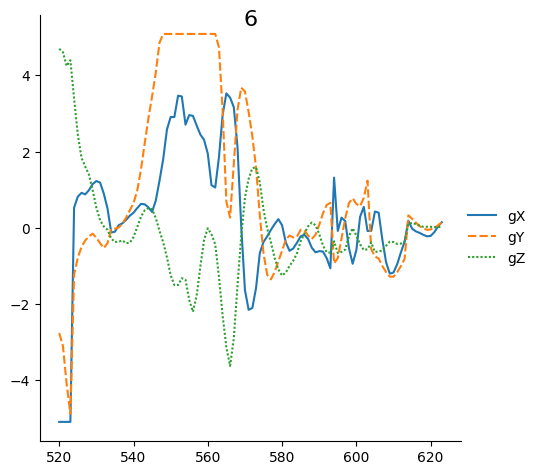

<Figure size 800x600 with 0 Axes>

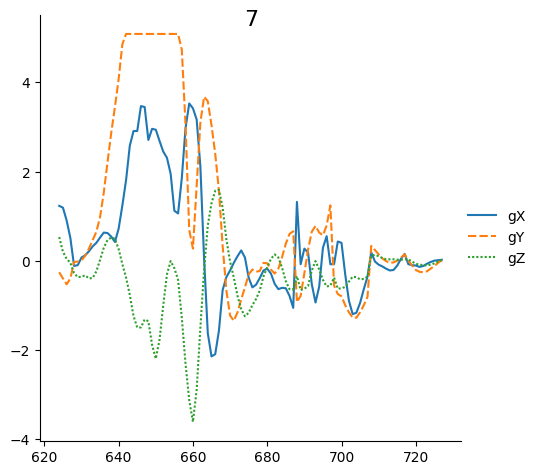

<Figure size 800x600 with 0 Axes>

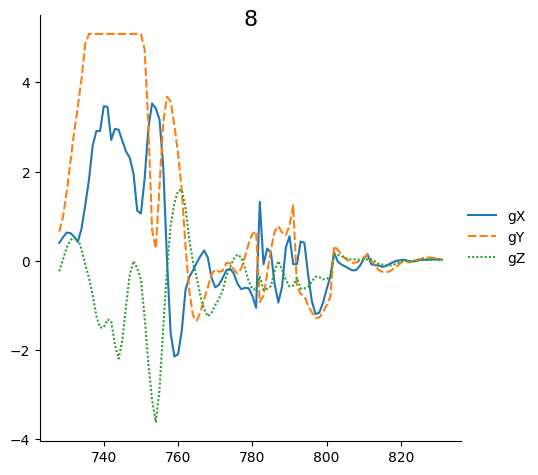

<Figure size 800x600 with 0 Axes>

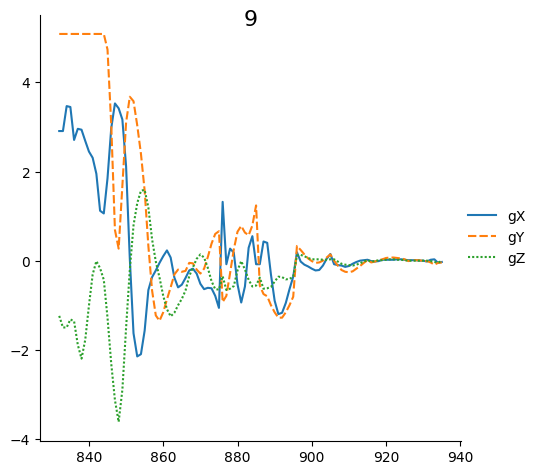

In [ ]:
for i in range (1, 10):
  a = get_nth_record(test, i, SAMPLES_PER_GESTURE)
  aa = a[['aX', 'aY', 'aZ']]
  ga = a[['gX', 'gY', 'gZ']]
  plt.figure(figsize=(8,6))
  a = sns.relplot(data=aa, kind='line')
  a.fig.suptitle(f"{i}", fontsize=16)
for i in range (1, 10):
  a = get_nth_record(test, i, SAMPLES_PER_GESTURE)
  aa = a[['aX', 'aY', 'aZ']]
  ga = a[['gX', 'gY', 'gZ']]
  plt.figure(figsize=(8,6))
  g = sns.relplot(data=ga, kind='line')
  g.fig.suptitle(f"{i}", fontsize=16)